## Testing look-elsewhere effect by creating 2d chi-square random fields with a Gaussian Process

by Kyle Cranmer, Dec 7, 2015

The correction for 2d look-elsewhere effect presented in 
*Estimating the significance of a signal in a multi-dimensional search* by  Ofer Vitells and Eilam Gross http://arxiv.org/pdf/1105.4355v1.pdf

is based on the fact that the test statistic

\begin{equation}
q(\nu_1, \nu_2) = -2 \log \frac{ \max_{\theta} L(\mu=0, \nu_1, \nu_2, \theta)}{ \max_{\mu, \theta} L(\mu, \nu_1, \nu_2, \theta)}
\end{equation}

is a chi-square random field (with 1 degree of freedom). That means that, for any point in $\nu_1, \nu_2$, the quantity $q(\nu_1, \nu_2)$ would have a chi-square distribution if you repeated the experiment many times.

That is what you expect if you have a background model $p_b(x|\theta)$ and you look for a signal on top of it with signal strength $\mu$. Creating that scan is somewhat time consuming, so here we make realizations of a chi-square random field by using a Gaussian Process. 
The main trick we will use is that a chi-square distribution for one degree of freedom is the same as the distribution of $x^2$ if $x$ is normally distributed. As you might have guessed, a Gaussian Process (GP) is like a chi-square random field, but it is Gaussian-distributed at each point.

Note, the distributions are not independent at each point, there is some covaraince. So if the $q(\nu_1, \nu_2)$ is high at one point, you can expect it to be high near by. We can control this behavior via the GP's kernel.

For more on the theory of Gaussian Processes, the best resource is available for free online: [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/). We will [`george`](http://dan.iel.fm/george/current/) -- a nice python package for Gaussian Processes (GP).



In [4]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


The main trick we will use is that a chi-square distribution for one degree of freedom is the same as the distribution of $x^2$ if $x$ is normally distributed. Here's a quick demonstration of that:

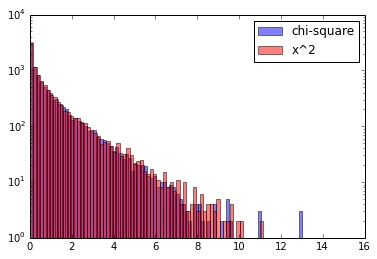

In [5]:
from scipy.stats import chi2, norm
chi2_array = chi2.rvs(1, size=10000)
norm_array = norm.rvs(size=10000)
_ = plt.hist(chi2_array, bins=100, alpha=.5, label='chi-square')
_ = plt.hist(norm_array**2, bins=100, alpha=.5, color='r', label='x^2')
plt.yscale('log', nonposy='clip')
plt.legend(('chi-square', 'x^2'))
#plt.semilogy()

### Ok, now to the Gaussian processes.

In [6]:
import george
from george.kernels import ExpSquaredKernel

In [7]:
length_scale_of_correaltion=0.1
kernel = ExpSquaredKernel(length_scale_of_correaltion, ndim=2)

In [8]:
# Create the Gaussian process
# gp = george.GP(kernel)
gp = george.GP(kernel, solver=george.HODLRSolver) #faster

In [9]:
n_scan_points=50
aspect_ratio =  10. # make excesses look like stripes
x_scan = np.arange(0,aspect_ratio,aspect_ratio/n_scan_points)
y_scan = np.arange(0,1,1./n_scan_points)
xx, yy = np.meshgrid(x_scan, y_scan)

In [10]:
# reformat the independent coordinates where we evaluate the GP
indep = np.vstack((np.hstack(xx),np.hstack(yy))).T

In [11]:
# illustration of what is being done here
np.vstack([[1,2],[3,4]]).T

array([[1, 3],
       [2, 4]])

In [12]:
# slow part: pre-compute internal stuff for the GP
gp.compute(indep)

In [13]:
# evaluate one realization of the GP
z = gp.sample(indep)

In [14]:
# reformat output for plotting
zz = z.reshape((n_scan_points,n_scan_points))

<matplotlib.colorbar.Colorbar instance at 0x10c0670e0>

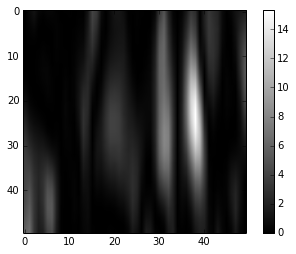

In [15]:
# plot the chi-square random field
plt.imshow(zz**2, cmap='gray')
plt.colorbar()

Now lets histogram the values of the random field.
Don't get confused here... if you pick a single point and histogram the value of over many instances, you expect a Gaussian. However, for a single instance, you don't expect the histogram for the value of the field to be Gaussian (because of the correlations). Thought experiments: if you make `length_scale_of_correaltion` very small, then each point is essentially independent and you do expect to see a Gaussian; however, if `length_scale_of_correaltion` is very large then you expect the field to be nearly constant and the histogram below would be a delta function.

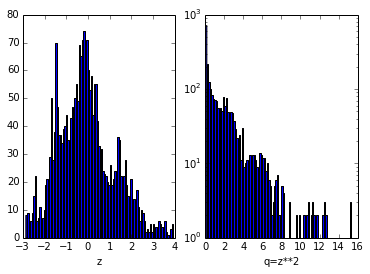

In [16]:
# plot the gaussian distributed x and chi-square distributed x**2
plt.subplot(1,2,1)
count, edges, patches = plt.hist(np.hstack(zz), bins=100)
plt.xlabel('z')
plt.subplot(1,2,2)
count, edges, patches = plt.hist(np.hstack(zz)**2, bins=100)
plt.xlabel('q=z**2')
plt.yscale('log', nonposy='clip')

## Ok, now let's repeat that several times and test lee2d

In [17]:
from lee2d import *


In [37]:
from scipy.ndimage import grey_closing, binary_closing

def fill_holes(array):
    zero_array = array==0.
    temp = grey_closing(array, size=2)*zero_array
    print np.sum(temp)
    return temp+array


Generate 25 realizations of the GP, calculate the Euler characteristic for two thresholds, and use the mean of those Euler characteristics to estimate $N_1$ and $N_2$

0.84008251292
1.07421037292
9.45671105564
3.67675031418
2.39271880675
4.41673419794
2.74658486914
3.98855998155
2.42989489918
5.19320087685
0.465411161491
1.26797652899
4.81617769522
1.23888787035
5.04054081538
9.03239355699
2.56575467823
2.2710098149
1.12810529755
1.59491819727
2.24852081996
3.10801460564
9.82453294559
2.07158212615
1.78837993117


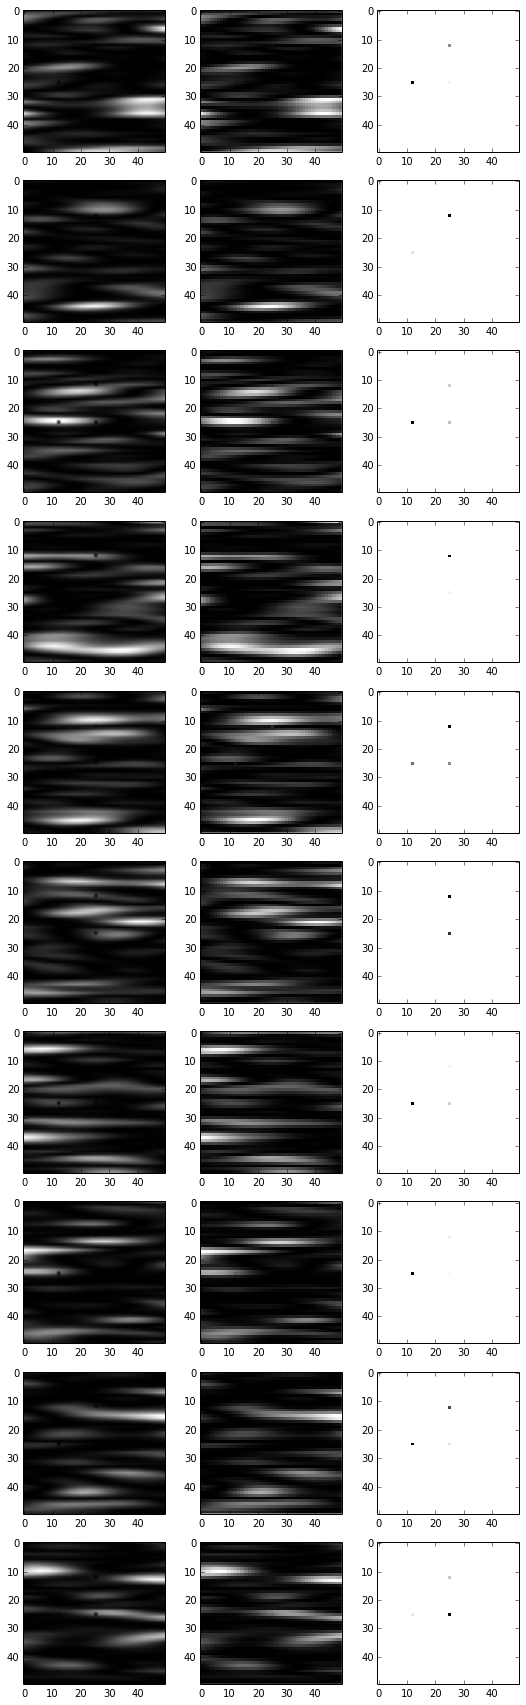

In [39]:
n_samples = 25
z_array = gp.sample(indep,n_samples)

q_max = np.zeros(n_samples)
phis = np.zeros((n_samples,2))

u1,u2 = 0.5, 1.

n_plots = 10
plt.figure(figsize=(9,n_plots*3))
for scan_no, z in enumerate(z_array):

    scan = z.reshape((n_scan_points,n_scan_points))**2

    q_max[scan_no] = np.max(scan)
    
    # set a point to 0 to simulate misc failure
    scan[n_scan_points/2,n_scan_points/2] = 0. 
    scan[n_scan_points/4,n_scan_points/2] = 0. 
    scan[n_scan_points/2,n_scan_points/4] = 0. 

    newscan = fill_holes(scan)
    diffscan = scan-newscan

    #get excursion sets above those two levels
    exc1 = (scan>u1) + 0. #add 0. to convert from bool to double
    exc2 = (scan>u2) + 0.
    #print '\nu1,u2 = ', u1, u2
    
    #print 'diff = ', np.sum(exc1), np.sum(exc2)
    
    if scan_no < n_plots:
        aspect = 1.
        plt.subplot(n_plots,3,3*scan_no+1)
        aspect = 1.*scan.shape[0]/scan.shape[1]
        plt.imshow(scan.T, cmap='gray', aspect=aspect)
        plt.subplot(n_plots,3,3*scan_no+2)
        #plt.imshow(exc1.T, cmap='gray', aspect=aspect, interpolation='none')
        plt.imshow(newscan.T, cmap='gray', aspect=aspect, interpolation='none')
        plt.subplot(n_plots,3,3*scan_no+3)
        plt.imshow(diffscan.T, cmap='gray', aspect=aspect, interpolation='none')


    phi1 = calculate_euler_characteristic(exc1)
    phi2 = calculate_euler_characteristic(exc2)
    #print 'phi1, phi2 = ', phi1, phi2
    #print 'q_max = ', np.max(scan)

    phis[scan_no] = [phi1, phi2]

plt.savefig('chi-square-random-fields.png')

In [40]:
exp_phi_1, exp_phi_2 = np.mean(phis[:,0]), np.mean(phis[:,1])
exp_phi_1, exp_phi_2

(14.32, 13.4)

In [41]:
n1, n2 = get_coefficients(u1=u1, u2=u2, exp_phi_1=exp_phi_1, exp_phi_2=exp_phi_2)
print n1, n2

8.60199674222 12.9677117014


With estimates of $N_1$ and $N_2$ predict the global p-value vs. u

In [42]:
u = np.linspace(5,25,100)
global_p = global_pvalue(u,n1,n2)

### Generate 5000 instances of the Gaussian Process, find maximum local significance for each, and check the prediction for the LEE-corrected global p-value

In [43]:
n_samples = 5000
z_array = gp.sample(indep,n_samples)

q_max = np.zeros(n_samples)

for scan_no, z in enumerate(z_array):
    scan = z.reshape((n_scan_points,n_scan_points))**2
    q_max[scan_no] = np.max(scan)

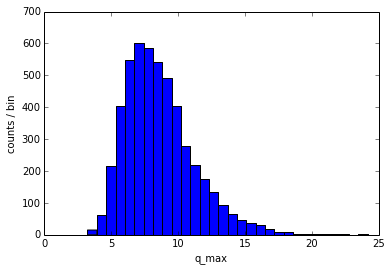

In [44]:
bins, edges, patches = plt.hist(q_max, bins=30)
icdf = 1.-np.cumsum(bins/n_samples)
icdf = np.hstack((1.,icdf))
icdf_error = np.sqrt(np.cumsum(bins))/n_samples
icdf_error = np.hstack((0.,icdf_error))
plt.xlabel('q_max')
plt.ylabel('counts / bin')

[]

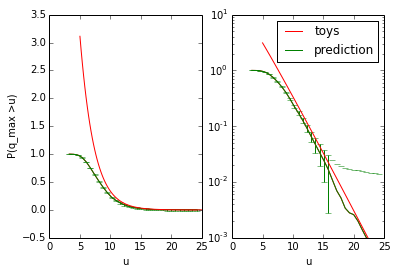

In [45]:
# plot the p-value 
plt.subplot(121)
plt.plot(edges,icdf, c='r')
plt.errorbar(edges,icdf,yerr=icdf_error)
plt.plot(u, global_p)
plt.xlabel('u')
plt.ylabel('P(q_max >u)')
plt.xlim(0,25)
plt.subplot(122)
plt.plot(edges,icdf, c='r', label='toys')
plt.errorbar(edges,icdf,yerr=icdf_error)
plt.plot(u, global_p, label='prediction')
plt.xlabel('u')
plt.legend(('toys', 'prediction'))
#plt.ylabel('P(q>u)')
plt.ylim(1E-3,10)
plt.xlim(0,25)
plt.semilogy()